## Projeto

Esse projeto em PySpark faz uso de uma base de dados de preços de combustíveis e indicadores de mercado para rodar modelos de aprendizado de máquina sobre séries temporais.

O objetivo é explicar variações de preços de distribuição ou revenda dos combustíveis a partir dos preços internacionais, usando como exemplo o preço da Gasolina no Estado de SP.

Ao selecionar apenas uma parte do conjunto de dados disponível estamos procurando reduzir ruídos relacionados a diferenças de localidade e tributação.

## Inicialização

In [1]:
from pyspark.sql import SparkSession

spark = ( SparkSession
    .builder
    .appName("analise-dados")
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar")
    .enableHiveSupport()
    .getOrCreate() )

spark._jsc.hadoopConfiguration().set('fs.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem')

23/10/15 03:34:40 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
spark.catalog.listDatabases()

ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used


[Database(name='default', description='Default Hive database', locationUri='gs://hadoop-dados-brutos/spark-warehouse'),
 Database(name='precos_anp', description='Base de dados de preços de combustíveis fornecidos pela ANP e alguns indicadores de mercado', locationUri='gs://hadoop-dados-brutos/spark-warehouse/precos_anp.db'),
 Database(name='precos_mkt', description='Base de dados de preços e indices de mercado', locationUri='gs://hadoop-dados-brutos/spark-warehouse/precos_mkt.db')]

In [3]:
spark.sql("SHOW TABLES FROM precos_anp").show()

+----------+--------------------+-----------+
| namespace|           tableName|isTemporary|
+----------+--------------------+-----------+
|precos_anp|combustiveis_auto...|      false|
|precos_anp|distribuicao_comb...|      false|
|precos_anp|media_distribuica...|      false|
|precos_anp|media_venda_combu...|      false|
+----------+--------------------+-----------+



In [4]:
spark.table('precos_anp.combustiveis_automotivos').printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- revenda: string (nullable = true)
 |-- cnpj_revenda: string (nullable = true)
 |-- endereco_rua: string (nullable = true)
 |-- endereco_numero: string (nullable = true)
 |-- endereco_complemento: string (nullable = true)
 |-- endereco_bairro: string (nullable = true)
 |-- endereco_cep: string (nullable = true)
 |-- produto: string (nullable = true)
 |-- data: date (nullable = true)
 |-- valor_venda: decimal(10,4) (nullable = true)
 |-- valor_compra: decimal(10,4) (nullable = true)
 |-- unidade_medida: string (nullable = true)
 |-- bandeira: string (nullable = true)
 |-- mes: string (nullable = true)



## Preparação de dados

Considerando a média semanal do preço de venda de GASOLINA para o Estado de São Paulo

In [5]:
from pyspark.sql import functions as F

produto = "GASOLINA"
estado = "SP"

df_valor_venda_medio_produto_estado = (
    spark.table('precos_anp.combustiveis_automotivos')
    .filter((F.col("produto") == produto) & (F.col("estado") == estado))
    .groupBy("data")
    .agg(F.avg("valor_venda").alias("valor_venda_medio"))
    .orderBy("data")
)

df_valor_venda_semana = (
    df_valor_venda_medio_produto_estado
    .withColumn("data_semana", F.date_trunc("week", "data"))
    .groupBy("data_semana")
    .agg(F.avg("valor_venda_medio").alias("preco_gasolina_semana"))
    .orderBy("data_semana")
)

df_valor_venda_semana.cache().show()

+-------------------+---------------------+
|        data_semana|preco_gasolina_semana|
+-------------------+---------------------+
|2004-05-10 00:00:00|       1.863359962500|
|2004-05-17 00:00:00|       1.873587342500|
|2004-05-24 00:00:00|       1.869737610000|
|2004-05-31 00:00:00|       1.915162670000|
|2004-06-07 00:00:00|       1.902190405000|
|2004-06-14 00:00:00|       1.926659077500|
|2004-06-21 00:00:00|       2.016088854000|
|2004-06-28 00:00:00|       2.022428865000|
|2004-07-05 00:00:00|       2.020650085000|
|2004-07-12 00:00:00|       2.016162407500|
|2004-07-19 00:00:00|       2.027905735000|
|2004-07-26 00:00:00|       2.016127377500|
|2004-08-02 00:00:00|       2.033061532500|
|2004-08-09 00:00:00|       2.022400987500|
|2004-08-16 00:00:00|       2.022099235000|
|2004-08-23 00:00:00|       2.024677992500|
|2004-08-30 00:00:00|       2.023586297500|
|2004-09-06 00:00:00|       2.009685497500|
|2004-09-13 00:00:00|       2.015331917500|
|2004-09-20 00:00:00|       2.01

Considerando o preço médio semanal dos indicadores de mercado internacional (petróleo e dólar)

In [6]:
spark.sql("SHOW TABLES FROM precos_mkt").show()

+----------+---------+-----------+
| namespace|tableName|isTemporary|
+----------+---------+-----------+
|precos_mkt|    brent|      false|
|precos_mkt|  brl_usd|      false|
|precos_mkt|     opep|      false|
|precos_mkt|      wti|      false|
+----------+---------+-----------+



In [7]:
df_wti_semana = (
    spark.table('precos_mkt.wti')
    .withColumn("data_semana", F.date_trunc("week", "data"))
    .groupBy("data_semana")
    .agg(F.avg("preco_wti").alias("preco_wti_semana"))
    .orderBy("data_semana")
)

df_wti_semana.cache().show()

+-------------------+----------------+
|        data_semana|preco_wti_semana|
+-------------------+----------------+
|2003-01-06 00:00:00|       31.538000|
|2003-01-13 00:00:00|       33.038000|
|2003-01-20 00:00:00|       34.455000|
|2003-01-27 00:00:00|       33.192000|
|2003-02-03 00:00:00|       33.954000|
|2003-02-10 00:00:00|       35.792000|
|2003-02-17 00:00:00|       36.777500|
|2003-02-24 00:00:00|       36.980000|
|2003-03-03 00:00:00|       36.976000|
|2003-03-10 00:00:00|       36.664000|
|2003-03-17 00:00:00|       30.456000|
|2003-03-24 00:00:00|       30.432000|
|2003-03-31 00:00:00|       29.326000|
|2003-04-07 00:00:00|       28.028000|
|2003-04-14 00:00:00|       29.282500|
|2003-04-21 00:00:00|       28.432000|
|2003-04-28 00:00:00|       25.690000|
|2003-05-05 00:00:00|       26.582000|
|2003-05-12 00:00:00|       28.540000|
|2003-05-19 00:00:00|       29.294000|
+-------------------+----------------+
only showing top 20 rows



In [8]:
df_brent_semana = (
    spark.table('precos_mkt.brent')
    .withColumn("data_semana", F.date_trunc("week", "data"))
    .groupBy("data_semana")
    .agg(F.avg("preco_brent").alias("preco_brent_semana"))
    .orderBy("data_semana")
)

df_brent_semana.cache().show()

+-------------------+------------------+
|        data_semana|preco_brent_semana|
+-------------------+------------------+
|2002-12-30 00:00:00|         30.875000|
|2003-01-06 00:00:00|         30.368000|
|2003-01-13 00:00:00|         31.482000|
|2003-01-20 00:00:00|         31.808000|
|2003-01-27 00:00:00|         31.200000|
|2003-02-03 00:00:00|         31.578000|
|2003-02-10 00:00:00|         32.786000|
|2003-02-17 00:00:00|         33.000000|
|2003-02-24 00:00:00|         33.720000|
|2003-03-03 00:00:00|         34.110000|
|2003-03-10 00:00:00|         33.724000|
|2003-03-17 00:00:00|         28.178000|
|2003-03-24 00:00:00|         26.950000|
|2003-03-31 00:00:00|         26.930000|
|2003-04-07 00:00:00|         24.962000|
|2003-04-14 00:00:00|         25.088000|
|2003-04-21 00:00:00|         24.878000|
|2003-04-28 00:00:00|         23.554000|
|2003-05-05 00:00:00|         24.308000|
|2003-05-12 00:00:00|         26.214000|
+-------------------+------------------+
only showing top

In [9]:
df_opep_semana = (
    spark.table('precos_mkt.opep')
    .withColumn("data_semana", F.date_trunc("week", "data"))
    .groupBy("data_semana")
    .agg(F.avg("preco_opep").alias("preco_opep_semana"))
    .orderBy("data_semana")
)

df_opep_semana.cache().show()

+-------------------+-----------------+
|        data_semana|preco_opep_semana|
+-------------------+-----------------+
|2002-12-30 00:00:00|        30.440000|
|2003-01-06 00:00:00|        29.724000|
|2003-01-13 00:00:00|        30.516000|
|2003-01-20 00:00:00|        30.748000|
|2003-01-27 00:00:00|        30.316000|
|2003-02-03 00:00:00|        30.562000|
|2003-02-10 00:00:00|        31.654000|
|2003-02-17 00:00:00|        31.804000|
|2003-02-24 00:00:00|        32.554000|
|2003-03-03 00:00:00|        32.266000|
|2003-03-10 00:00:00|        32.358000|
|2003-03-17 00:00:00|        27.186000|
|2003-03-24 00:00:00|        26.394000|
|2003-03-31 00:00:00|        26.232000|
|2003-04-07 00:00:00|        25.238000|
|2003-04-14 00:00:00|        25.717500|
|2003-04-21 00:00:00|        25.278000|
|2003-04-28 00:00:00|        23.664000|
|2003-05-05 00:00:00|        24.276000|
|2003-05-12 00:00:00|        25.862000|
+-------------------+-----------------+
only showing top 20 rows



In [10]:
df_brl_usd_semana = (
    spark.table('precos_mkt.brl_usd')
    .withColumn("data_semana", F.date_trunc("week", "data"))
    .groupBy("data_semana")
    .agg(F.avg("brl_usd").alias("brl_usd_semana"))
    .orderBy("data_semana")
)

df_brl_usd_semana.cache().show()

+-------------------+--------------+
|        data_semana|brl_usd_semana|
+-------------------+--------------+
|2002-12-30 00:00:00|    3.50166667|
|2003-01-06 00:00:00|    3.31570000|
|2003-01-13 00:00:00|    3.31270000|
|2003-01-20 00:00:00|    3.51850000|
|2003-01-27 00:00:00|    3.57960000|
|2003-02-03 00:00:00|    3.57200000|
|2003-02-10 00:00:00|    3.62060000|
|2003-02-17 00:00:00|    3.60940000|
|2003-02-24 00:00:00|    3.57180000|
|2003-03-03 00:00:00|    3.53220000|
|2003-03-10 00:00:00|    3.46600000|
|2003-03-17 00:00:00|    3.44450000|
|2003-03-24 00:00:00|    3.37220000|
|2003-03-31 00:00:00|    3.28350000|
|2003-04-07 00:00:00|    3.19440000|
|2003-04-14 00:00:00|    3.07920000|
|2003-04-21 00:00:00|    3.00210000|
|2003-04-28 00:00:00|    2.93660000|
|2003-05-05 00:00:00|    2.95470000|
|2003-05-12 00:00:00|    2.92400000|
+-------------------+--------------+
only showing top 20 rows



Fazendo a junção dos dados de preços em médias semanais (Gasolina, WTI, Brent, OPEP, BRL/USD)

In [11]:
df_gasolina_mkt = (
    df_valor_venda_semana.alias('g').join(
        df_wti_semana.alias('w'), F.col("w.data_semana") == F.col("g.data_semana"), how="inner"
    ).join(
        df_brent_semana.alias('b'), F.col("b.data_semana") == F.col("g.data_semana"), how="inner"
    ).join(
        df_opep_semana.alias('o'), F.col("o.data_semana") == F.col("g.data_semana"), how="inner"
    ).join(
        df_brl_usd_semana.alias('u'), F.col("u.data_semana") == F.col("g.data_semana"), how="inner"
    )
    .select(
        F.col("g.data_semana"),
        F.col("g.preco_gasolina_semana"),
        F.col("w.preco_wti_semana"),
        F.col("b.preco_brent_semana"),
        F.col("o.preco_opep_semana"),
        F.col("u.brl_usd_semana")
    )
)

df_gasolina_mkt.cache().show()

+-------------------+---------------------+----------------+------------------+-----------------+--------------+
|        data_semana|preco_gasolina_semana|preco_wti_semana|preco_brent_semana|preco_opep_semana|brl_usd_semana|
+-------------------+---------------------+----------------+------------------+-----------------+--------------+
|2004-05-10 00:00:00|       1.863359962500|       40.372000|         37.618000|        36.466000|    3.11610000|
|2004-05-17 00:00:00|       1.873587342500|       40.842000|         38.430000|        37.122000|    3.15780000|
|2004-05-24 00:00:00|       1.869737610000|       40.646000|         37.952000|        36.686000|    3.13820000|
|2004-05-31 00:00:00|       1.915162670000|       40.005000|         37.254000|        36.282000|    3.15040000|
|2004-06-07 00:00:00|       1.902190405000|       37.987500|         35.342000|        34.436000|    3.12236000|
|2004-06-14 00:00:00|       1.926659077500|       37.856000|         35.090000|        34.364000

## Visualização de dados

Antes de iniciar o aprendizado estatístico é importante visualizar os dados para os primeiros insights.

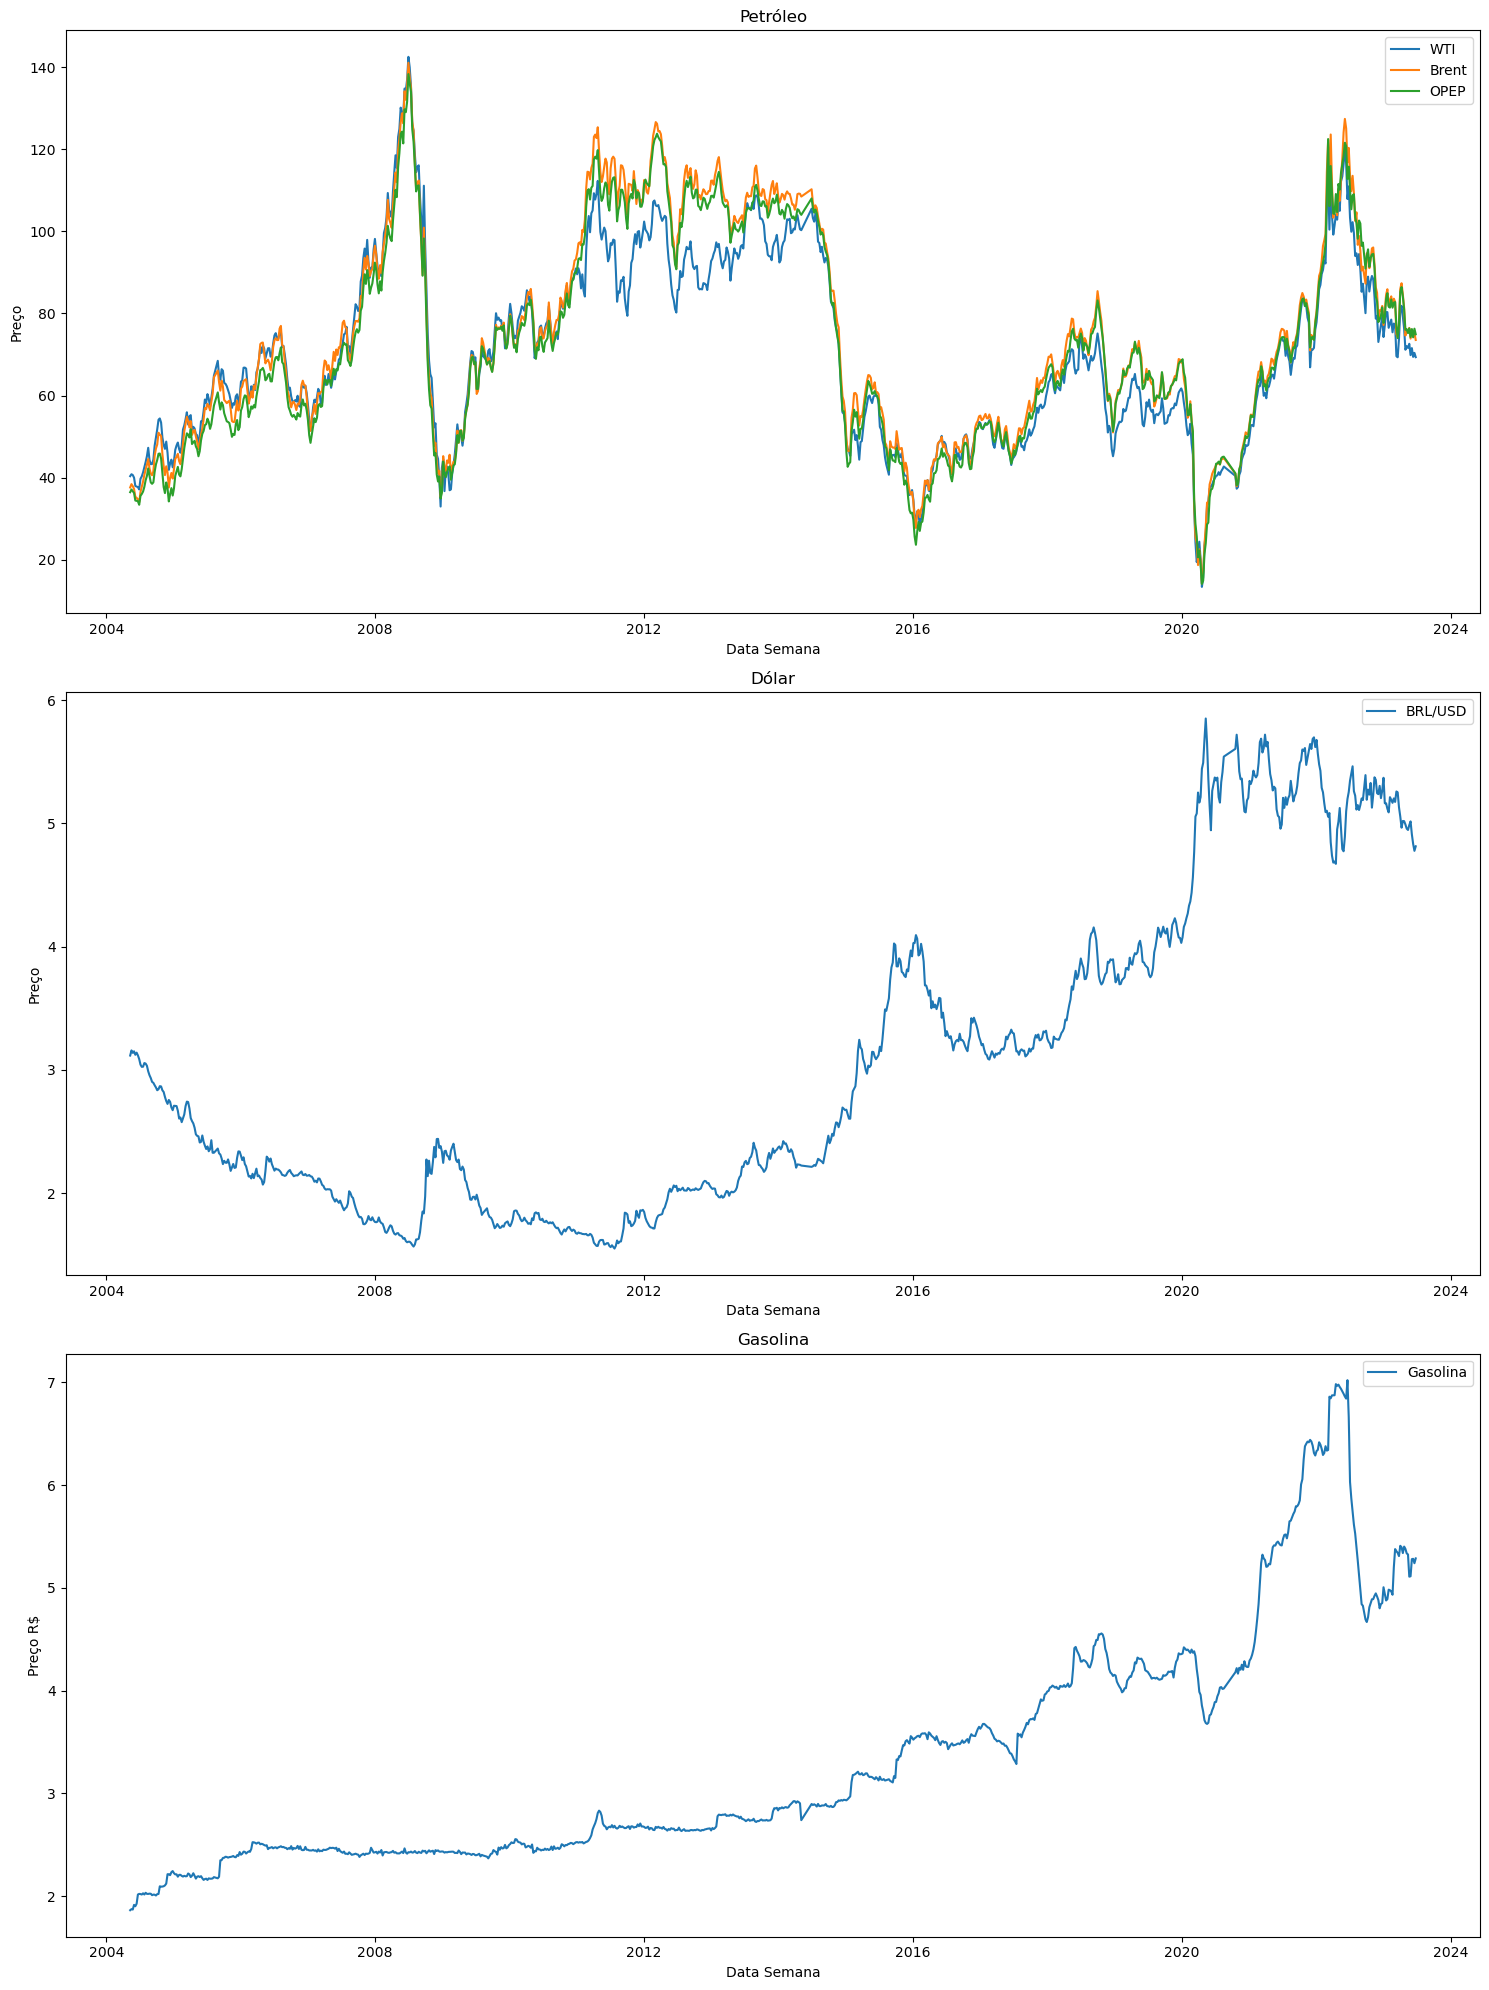

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

df = df_gasolina_mkt.toPandas()

fig, axes = plt.subplots(3, 1, figsize=(15, 20))

axes[0].plot(df['data_semana'], df['preco_wti_semana'], label='WTI')
axes[0].plot(df['data_semana'], df['preco_brent_semana'], label='Brent')
axes[0].plot(df['data_semana'], df['preco_opep_semana'], label='OPEP')
axes[0].set_xlabel('Data Semana')
axes[0].set_ylabel('Preço')
axes[0].set_title('Petróleo')
axes[0].legend()

axes[1].plot(df['data_semana'], df['brl_usd_semana'], label='BRL/USD')
axes[1].set_xlabel('Data Semana')
axes[1].set_ylabel('Preço')
axes[1].set_title('Dólar')
axes[1].legend()

axes[2].plot(df['data_semana'], df['preco_gasolina_semana'], label='Gasolina')
axes[2].set_xlabel('Data Semana')
axes[2].set_ylabel('Preço R$')
axes[2].set_title('Gasolina')
axes[2].legend()

plt.tight_layout()
plt.show()

## Derivando as séries temporais

Em muitos casos, séries temporais apresentam uma certa tendência ao longo do tempo, seja ela ascendente, descendente ou até cíclica. O problema com as tendências é que elas podem distorcer as relações entre as variáveis quando você está interessado em analisar correlações ou outras características estatísticas.

O processo de calcular a derivada da série temporal, ou seja, calcular as taxas de variação instantânea dos valores ao longo do tempo, tem o objetivo de entender melhor as mudanças ou tendências nos dados ao longo do tempo. 

Uma série temporal não estacionária é aquela em que as estatísticas, como média e variância, mudam ao longo do tempo. Geralmente, isso ocorre devido à presença de uma tendência ou sazonalidade nos dados. Quando você calcula a derivada da série temporal, está removendo a componente de tendência linear dos dados. A série resultante, que é a derivada, geralmente terá uma média constante e uma variância mais estável ao longo do tempo, tornando-a mais estacionária.

A transformação de uma série temporal não estacionária em uma série estacionária pode ser feita de diversas maneiras. Uma das maneiras mais simples é aplicar a diferenciação na série temporal usando a diferença entre pontos consecutivos. Isso envolve subtrair o valor atual do valor anterior em cada observação.

- Referências:
    - [Previsão de Demanda de Vinhos com Séries Temporais](https://pt.linkedin.com/pulse/previs%C3%A3o-de-demanda-vinhos-com-s%C3%A9ries-temporais-gabriel-martini)
    - [Análise de Séries Temporais](https://www.maxwell.vrac.puc-rio.br/4244/4244_5.PDF)

In [47]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

w = Window.partitionBy(F.lit("const")).orderBy("data_semana")

df_gasolina_mkt_detrend = (
    df_gasolina_mkt
      .withColumn("preco_gasolina_semana_diff",
                  (F.col("preco_gasolina_semana") - F.lag("preco_gasolina_semana", 1).over(w) )
      )
      .withColumn("preco_wti_semana_diff",
                  (F.col("preco_wti_semana") - F.lag("preco_wti_semana", 1).over(w))
      )
      .withColumn("preco_brent_semana_diff",
                  (F.col("preco_brent_semana") - F.lag("preco_brent_semana", 1).over(w))
      )
      .withColumn("preco_opep_semana_diff",
                  (F.col("preco_opep_semana") - F.lag("preco_opep_semana", 1).over(w))
      )
      .withColumn("brl_usd_semana_diff",
                  (F.col("brl_usd_semana") - F.lag("brl_usd_semana", 1).over(w))
      )
)

(
    df_gasolina_mkt_detrend.cache()
    .select("data_semana",
            "preco_gasolina_semana_diff",
            "preco_wti_semana_diff",
            "preco_brent_semana_diff",
            "preco_opep_semana_diff",
            "brl_usd_semana_diff"
    )
).show()

23/10/15 05:05:06 WARN CacheManager: Asked to cache already cached data.


+-------------------+--------------------------+---------------------+-----------------------+----------------------+-------------------+
|        data_semana|preco_gasolina_semana_diff|preco_wti_semana_diff|preco_brent_semana_diff|preco_opep_semana_diff|brl_usd_semana_diff|
+-------------------+--------------------------+---------------------+-----------------------+----------------------+-------------------+
|2004-05-10 00:00:00|                      null|                 null|                   null|                  null|               null|
|2004-05-17 00:00:00|            0.010227380000|             0.470000|               0.812000|              0.656000|         0.04170000|
|2004-05-24 00:00:00|           -0.003849732500|            -0.196000|              -0.478000|             -0.436000|        -0.01960000|
|2004-05-31 00:00:00|            0.045425060000|            -0.641000|              -0.698000|             -0.404000|         0.01220000|
|2004-06-07 00:00:00|           -0

Como hipótese, podemos declarar que as variações de preço da Gasolina são influenciadas por alterações de preços do mercado de Petróleo e Dólar em um passado recente. Para verificar podemos calcular as correlações cruzadas para diferentes atrasos de tempo.

- Referências:
    - [Como fazer uma análise de correlação em dados de séries temporais com o R](https://blog.metodosquantitativos.com/correlacao_cruzada/correlacaocruzada.html)

In [46]:
import warnings

# Atraso máximo na comparação de preços entre as séries históricas (ex: 4 semanas)
MAX_LAG = 4

# Função para calcular a correlação entre 2 séries considerando diferentes atrasos
def calcula_correlacoes_com_lag(df, col1, col2):
    correlacoes = []

    for lag in range(0, MAX_LAG+1):
        w = Window.partitionBy(F.lit("const")).orderBy("data_semana")
        
        # Aplicar o lag na segunda coluna
        df_lagged = df.withColumn(f"{col2}_lagged", F.lag(col2, lag).over(w))

        # Eliminar linhas com valores nulos resultantes do lag
        df_lagged = df_lagged.dropna()

        # Calcular a correlação entre as colunas
        corr = df_lagged.corr(col1, f"{col2}_lagged")

        # Armazenar o resultado
        correlacoes.append((lag, corr))
       
    return correlacoes

In [48]:
print("Correlações entre Gasolina e WTI")

correlacoes = calcula_correlacoes_com_lag(df_gasolina_mkt_detrend,
                                          "preco_gasolina_semana_diff", "preco_wti_semana_diff")
for lag, corr in correlacoes:
    print(f":. Lag: {lag}, Correlação: {corr}")

print("Correlações entre Gasolina e BRENT")

correlacoes = calcula_correlacoes_com_lag(df_gasolina_mkt_detrend,
                                          "preco_gasolina_semana_diff", "preco_brent_semana_diff")
for lag, corr in correlacoes:
    print(f":. Lag: {lag}, Correlação: {corr}")

print("Correlações entre Gasolina e OPEP")

correlacoes = calcula_correlacoes_com_lag(df_gasolina_mkt_detrend,
                                          "preco_gasolina_semana_diff", "preco_opep_semana_diff")
for lag, corr in correlacoes:
    print(f":. Lag: {lag}, Correlação: {corr}")

print("Correlações entre Gasolina e Dólar")

correlacoes = calcula_correlacoes_com_lag(df_gasolina_mkt_detrend,
                                          "preco_gasolina_semana_diff", "brl_usd_semana_diff")
for lag, corr in correlacoes:
    print(f":. Lag: {lag}, Correlação: {corr}")


Correlações entre Gasolina e WTI


:. Lag: 0, Correlação: 0.014052152326960117
:. Lag: 1, Correlação: 0.12151242876863418
:. Lag: 2, Correlação: 0.18789995621016772
:. Lag: 3, Correlação: 0.13267875362662584
:. Lag: 4, Correlação: 0.08176672806292178
Correlações entre Gasolina e BRENT


:. Lag: 0, Correlação: 0.01091014640889821
:. Lag: 1, Correlação: 0.13575114995016382
:. Lag: 2, Correlação: 0.1942750339470252
:. Lag: 3, Correlação: 0.15111500511102471
:. Lag: 4, Correlação: 0.08009024255943938
Correlações entre Gasolina e OPEP


:. Lag: 0, Correlação: 0.015372329203117659
:. Lag: 1, Correlação: 0.16112516906830968
:. Lag: 2, Correlação: 0.1887458458747821
:. Lag: 3, Correlação: 0.13996678792538247
:. Lag: 4, Correlação: 0.07664189223756337
Correlações entre Gasolina e Dólar


:. Lag: 0, Correlação: -0.030473355533472312
:. Lag: 1, Correlação: -0.044828617185167105
:. Lag: 2, Correlação: -0.01751822514105464
:. Lag: 3, Correlação: -0.06599511025236303
:. Lag: 4, Correlação: -0.061400434068232694


Chegamos a conclusão que as variações de preço da Gasolina tem maior correlação com variações de preço do Petróleo de 2 semanas atrás.
- Gasolina x WTI: 0.1879 (lag 2)
- Gasolina x BRENT: 0.1942 (lag 2)
- Gasolina x OPEP: 0.3676 (lag 2)
- Gasolina x Dolar: perto de zero (lag 0)

Para preparação de dados efetuamos o deslocamento de 2 observações nas colunas de preço de Petróleo

In [129]:
w = Window.partitionBy(F.lit("const")).orderBy("data_semana")

df_gasolina_mkt_detrend_lagged = (
    df_gasolina_mkt_detrend
    .withColumn(f"preco_wti_semana", F.lag("preco_wti_semana", 2).over(w))
    .withColumn(f"preco_wti_semana_diff", F.lag("preco_wti_semana_diff", 2).over(w))
    .withColumn(f"preco_brent_semana", F.lag("preco_brent_semana", 2).over(w))
    .withColumn(f"preco_brent_semana_diff", F.lag("preco_brent_semana_diff", 2).over(w))
    .withColumn(f"preco_opep_semana", F.lag("preco_opep_semana", 2).over(w))
    .withColumn(f"preco_opep_semana_diff", F.lag("preco_opep_semana_diff", 2).over(w))
)


# Imprimindo últimos valores das séries para comparação
(
    df_gasolina_mkt_detrend_lagged
    .orderBy("data_semana", ascending=False)
    .show(3, vertical=True)
)


-RECORD 0-----------------------------------------
 data_semana                | 2023-06-26 00:00:00 
 preco_gasolina_semana      | 5.287179322000      
 preco_wti_semana           | 69.422000           
 preco_brent_semana         | 74.388000           
 preco_opep_semana          | 74.190000           
 brl_usd_semana             | 4.81394000          
 preco_gasolina_semana_diff | 0.046754579500      
 preco_wti_semana_diff      | -2.140000           
 preco_brent_semana_diff    | -1.672000           
 preco_opep_semana_diff     | -2.006000           
 brl_usd_semana_diff        | 0.03680000          
-RECORD 1-----------------------------------------
 data_semana                | 2023-06-19 00:00:00 
 preco_gasolina_semana      | 5.240424742500      
 preco_wti_semana           | 71.562000           
 preco_brent_semana         | 76.060000           
 preco_opep_semana          | 76.196000           
 brl_usd_semana             | 4.77714000          
 preco_gasolina_semana_diff | -

## Aprendizado estatístico

Nosso conjunto de dados para rodar o aprendizado estatístico está pronto

In [52]:
df_dataset = (
    df_gasolina_mkt_detrend_lagged
    .select("data_semana",
            "preco_gasolina_semana_diff",
            "preco_wti_semana_diff",
            "preco_brent_semana_diff",
            "preco_opep_semana_diff",
            "brl_usd_semana_diff")
    .dropna()
)

df_dataset.show(10)

+-------------------+--------------------------+---------------------+-----------------------+----------------------+-------------------+
|        data_semana|preco_gasolina_semana_diff|preco_wti_semana_diff|preco_brent_semana_diff|preco_opep_semana_diff|brl_usd_semana_diff|
+-------------------+--------------------------+---------------------+-----------------------+----------------------+-------------------+
|2004-05-31 00:00:00|            0.045425060000|             0.470000|               0.812000|              0.656000|         0.01220000|
|2004-06-07 00:00:00|           -0.012972265000|            -0.196000|              -0.478000|             -0.436000|        -0.02804000|
|2004-06-14 00:00:00|            0.024468672500|            -0.641000|              -0.698000|             -0.404000|         0.01724000|
|2004-06-21 00:00:00|            0.089429776500|            -2.017500|              -1.912000|             -1.846000|        -0.02200000|
|2004-06-28 00:00:00|            0

Usando o MLib para criar o vetor de características que vão explicar a variação do preço da Gasolina

In [59]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["preco_wti_semana_diff", "preco_brent_semana_diff", "preco_opep_semana_diff", "brl_usd_semana_diff"],outputCol="features")

# Criando o dataframe de features e labels usando o assembler
features = (
    assembler
    .transform(df_dataset)
    .select("preco_gasolina_semana_diff", "features")
    .withColumnRenamed("preco_gasolina_semana_diff", "label")
)
features.show(truncate=False)

+---------------+-------------------------------+
|label          |features                       |
+---------------+-------------------------------+
|0.045425060000 |[0.47,0.812,0.656,0.0122]      |
|-0.012972265000|[-0.196,-0.478,-0.436,-0.02804]|
|0.024468672500 |[-0.641,-0.698,-0.404,0.01724] |
|0.089429776500 |[-2.0175,-1.912,-1.846,-0.022] |
|0.006340011000 |[-0.1315,-0.252,-0.072,-0.0301]|
|-0.001778780000|[-0.154,-0.382,-0.104,-0.045]  |
|-0.004487677500|[-0.562,-0.706,-0.86,-0.0181]  |
|0.011743327500 |[2.5875,2.504,2.178,0.0012]    |
|-0.011778357500|[0.5985,1.258,0.45,0.0297]     |
|0.016934155000 |[0.948,1.288,0.592,-0.0044]    |
|-0.010660545000|[1.226,1.612,1.154,-0.01784]   |
|-0.000301752500|[1.306,1.344,1.602,-0.04516]   |
|0.002578757500 |[1.438,1.15,1.066,-0.03158]    |
|-0.001091695000|[2.034,1.406,1.814,-0.02302]   |
|-0.013900800000|[-2.942,-2.336,-1.812,-0.0307] |
|0.005646420000 |[-1.052,-1.228,-1.596,-0.0078] |
|-0.000953387500|[0.046,-0.404,-0.34,-0.0198]   |


Normalizando os valores das variáveis independentes (pode dificultar a execução da predição do modelo pois será necessário normalizar também os novos dados).

In [103]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)

# Ajusta o modelo de normalização aos dados
sm = scaler.fit(features)

# Aplica a transformação
scaled_features = sm.transform(features)

scaled_features.show()

+---------------+--------------------+--------------------+
|          label|            features|     scaled_features|
+---------------+--------------------+--------------------+
| 0.045425060000|[0.47,0.812,0.656...|[0.14827330212263...|
|-0.012972265000|[-0.196,-0.478,-0...|[-0.0760539782439...|
| 0.024468672500|[-0.641,-0.698,-0...|[-0.2259423262366...|
| 0.089429776500|[-2.0175,-1.912,-...|[-0.6895857217690...|
| 0.006340011000|[-0.1315,-0.252,-...|[-0.0543285884787...|
|-0.001778780000|[-0.154,-0.382,-0...|[-0.0619072128154...|
|-0.004487677500|[-0.562,-0.706,-0...|[-0.1993329341210...|
| 0.011743327500|[2.5875,2.504,2.1...|[0.86150605914397...|
|-0.011778357500|[0.5985,1.258,0.4...|[0.19155566777894...|
| 0.016934155000|[0.948,1.288,0.59...|[0.30927696580915...|
|-0.010660545000|[1.226,1.612,1.15...|[0.40291507983603...|
|-0.000301752500|[1.306,1.344,1.60...|[0.42986129969989...|
| 0.002578757500|[1.438,1.15,1.066...|[0.47432256247524...|
|-0.001091695000|[2.034,1.406,1.81...|[0

Gerando os dados de treino e teste (70%, 30%) de forma aleatória

In [104]:
(training_data, test_data) = scaled_features.randomSplit([0.7, 0.3])
print(training_data.count(), test_data.count())

675 300


Idéia é usar uma regressão linear para obter a variação do preço da Gasolina com base na variação dos preços de Petróleo (WTI, OPEP, BRENT) e Dólar

In [110]:
from pyspark.ml.regression import LinearRegression, LinearRegressionTrainingSummary

FEATURES_COL = "features"

# Estimator
lr = LinearRegression(labelCol="label", featuresCol=FEATURES_COL)

# Treinamento
lr_modelo = lr.fit(training_data)

# Resultados
print(f"Coefficients: {lr_modelo.coefficients}")
print(f"Intercept: {lr_modelo.intercept}")
print(f"MSE: {lr_modelo.summary.meanSquaredError}")
print(f"RMSE: {lr_modelo.summary.rootMeanSquaredError}")
print(f"R2: {lr_modelo.summary.r2}")

23/10/15 06:17:24 WARN Instrumentation: [cf31e52a] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [-0.0006273139064942553,0.003037453894038474,-0.0008285446377558213,-0.03489856990732614]
Intercept: 0.0037554996909569187
MSE: 0.0015914827633603603
RMSE: 0.03989339247745622
R2: 0.02030909866620112


O modelo de regressão linear parece não ter um bom ajuste aos dados, com um baixo valor de R2 (ideal que seja mais próximo de 1) embora os valores de erro (MSE e RMSE) sejam relativamente baixos.

Os coeficientes indicam como cada variável independente contribui para a previsão da variável dependente.

Testando o modelo na base de teste

In [107]:
resultado = lr_modelo.transform(test_data)
resultado.show()

+---------------+--------------------+--------------------+--------------------+
|          label|            features|     scaled_features|          prediction|
+---------------+--------------------+--------------------+--------------------+
|-0.632122806000|[-8.5735,-8.252,-...|[-2.8978284396117...|-0.01256097249706...|
|-0.216213002000|[0.87,1.4625,0.11...|[0.28300440144189...|0.006187877793991325|
|-0.163737696667|[-1.8355,0.136,-0...|[-0.6282830715787...|0.005676004258442944|
|-0.137100172000|[0.644,2.1,-1.404...|[0.20688133032651...|0.012294965951542806|
|-0.128816325000|[-4.756,-1.692,-3...|[-1.6119885104835...|0.006944936098683085|
|-0.126845215000|[-13.188,-16.978,...|[-4.4521200841335...|-0.02665084088790...|
|-0.126547260000|[-2.636,-4.258,0....|[-0.8979136840914...|-0.00380786236355729|
|-0.088052408000|[2.32,3.734,3.384...|[0.77140463647421...|0.012114778901274199|
|-0.084223872500|[-6.72,-5.759,-4....|[-2.2735182081410...|-0.01216199596028...|
|-0.065837530667|[-3.272,-3.

Avaliando a qualidade do modelo na base de teste

In [73]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(resultado)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 0.03930657482954522


Testando o modelo para uma nova variação nos preços de Petróleo e Dolar. Ao análisar diferentes valores notamos que o resultado não condiz com variações que esparavamos, pois sabemos o quanto o preço da Gasolina é suscetível a essas variações.

In [126]:
nova_variacao = Vectors.dense(+10, +10, +10, +0.2)
print(lr_modelo.predict(nova_variacao))

nova_variacao = Vectors.dense(0, 0, 0, +0.5)
print(lr_modelo.predict(nova_variacao))

nova_variacao = Vectors.dense(-20, -20, -20, -0.4)
print(lr_modelo.predict(nova_variacao))

0.012591739207375665
-0.013693785262706152
-0.013916979341880572


## Conclusão e trabalhos futuros

Nosso modelo não foi satisfatório em explicar variações no preço da Gasolina a partir de variações semanais nos preços internacionais de Petróleo e Dólar, talvez porque não tenhamos encontrado uma boa correlação entre as séries temporais levando em conta o período de quase 20 anos. Seria, porém, interessante evoluir a análise das informações e refinar o aprendizado estatístico para se chegar a um modelo mais adequado.

Idéias de trabalho futuro:
- Incluir elementos na análise que envolvam decisões governamentais e mudanças de tributação.
- Dividir a séries temporais por marcos relevantes para adotar análises e modelos específicos a cada partição das séries.
- Trabalhar com outras estimativas (média ponderada, etc) e frequências de variação de preço (2 semanas, mensal, etc).
- Reproduzir o estudo com outros produtos (Etanol, Diesel) e localidades.
- Trabalhar na relação entre os preços de revenda e preços de distribuição dos combustíveis.